In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import sklearn
sklearn.set_config(transform_output="pandas")
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Lasso
# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, RobustScaler
from sklearn.model_selection import GridSearchCV, KFold
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import VotingRegressor, StackingRegressor

from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import root_mean_squared_log_error, mean_squared_error
# tunning hyperparamters model
import optuna
import shap
import sweetviz as sv
import missingno as msno
# from tqdm import tqdm

In [255]:
filetrain = 'data/train.csv'
train = pd.read_csv(filetrain)
X, y = train.drop('SalePrice', axis=1), train['SalePrice']
testfile = 'data/test.csv'
test =  pd.read_csv(testfile)

In [258]:
num_features = train.select_dtypes(exclude='object')
cat_features = train.select_dtypes(include='object')

### Графики

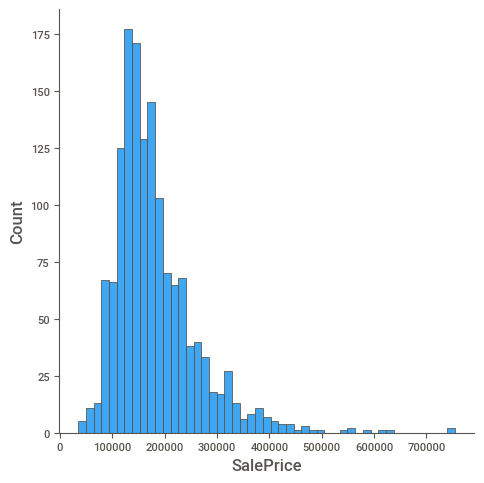

In [257]:
sns.displot(train['SalePrice'])

### Sweetviz

In [256]:
report = sv.compare([train, 'Train'], [test, 'Test'])

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:12 -> (00:00 left)


In [247]:
report_single = sv.analyze(train)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:06 -> (00:00 left)


In [248]:
report.show_html('report.html')

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [249]:
report_single.show_html('report_single.html')

Report report_single.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [252]:
sns.set()

<Axes: >

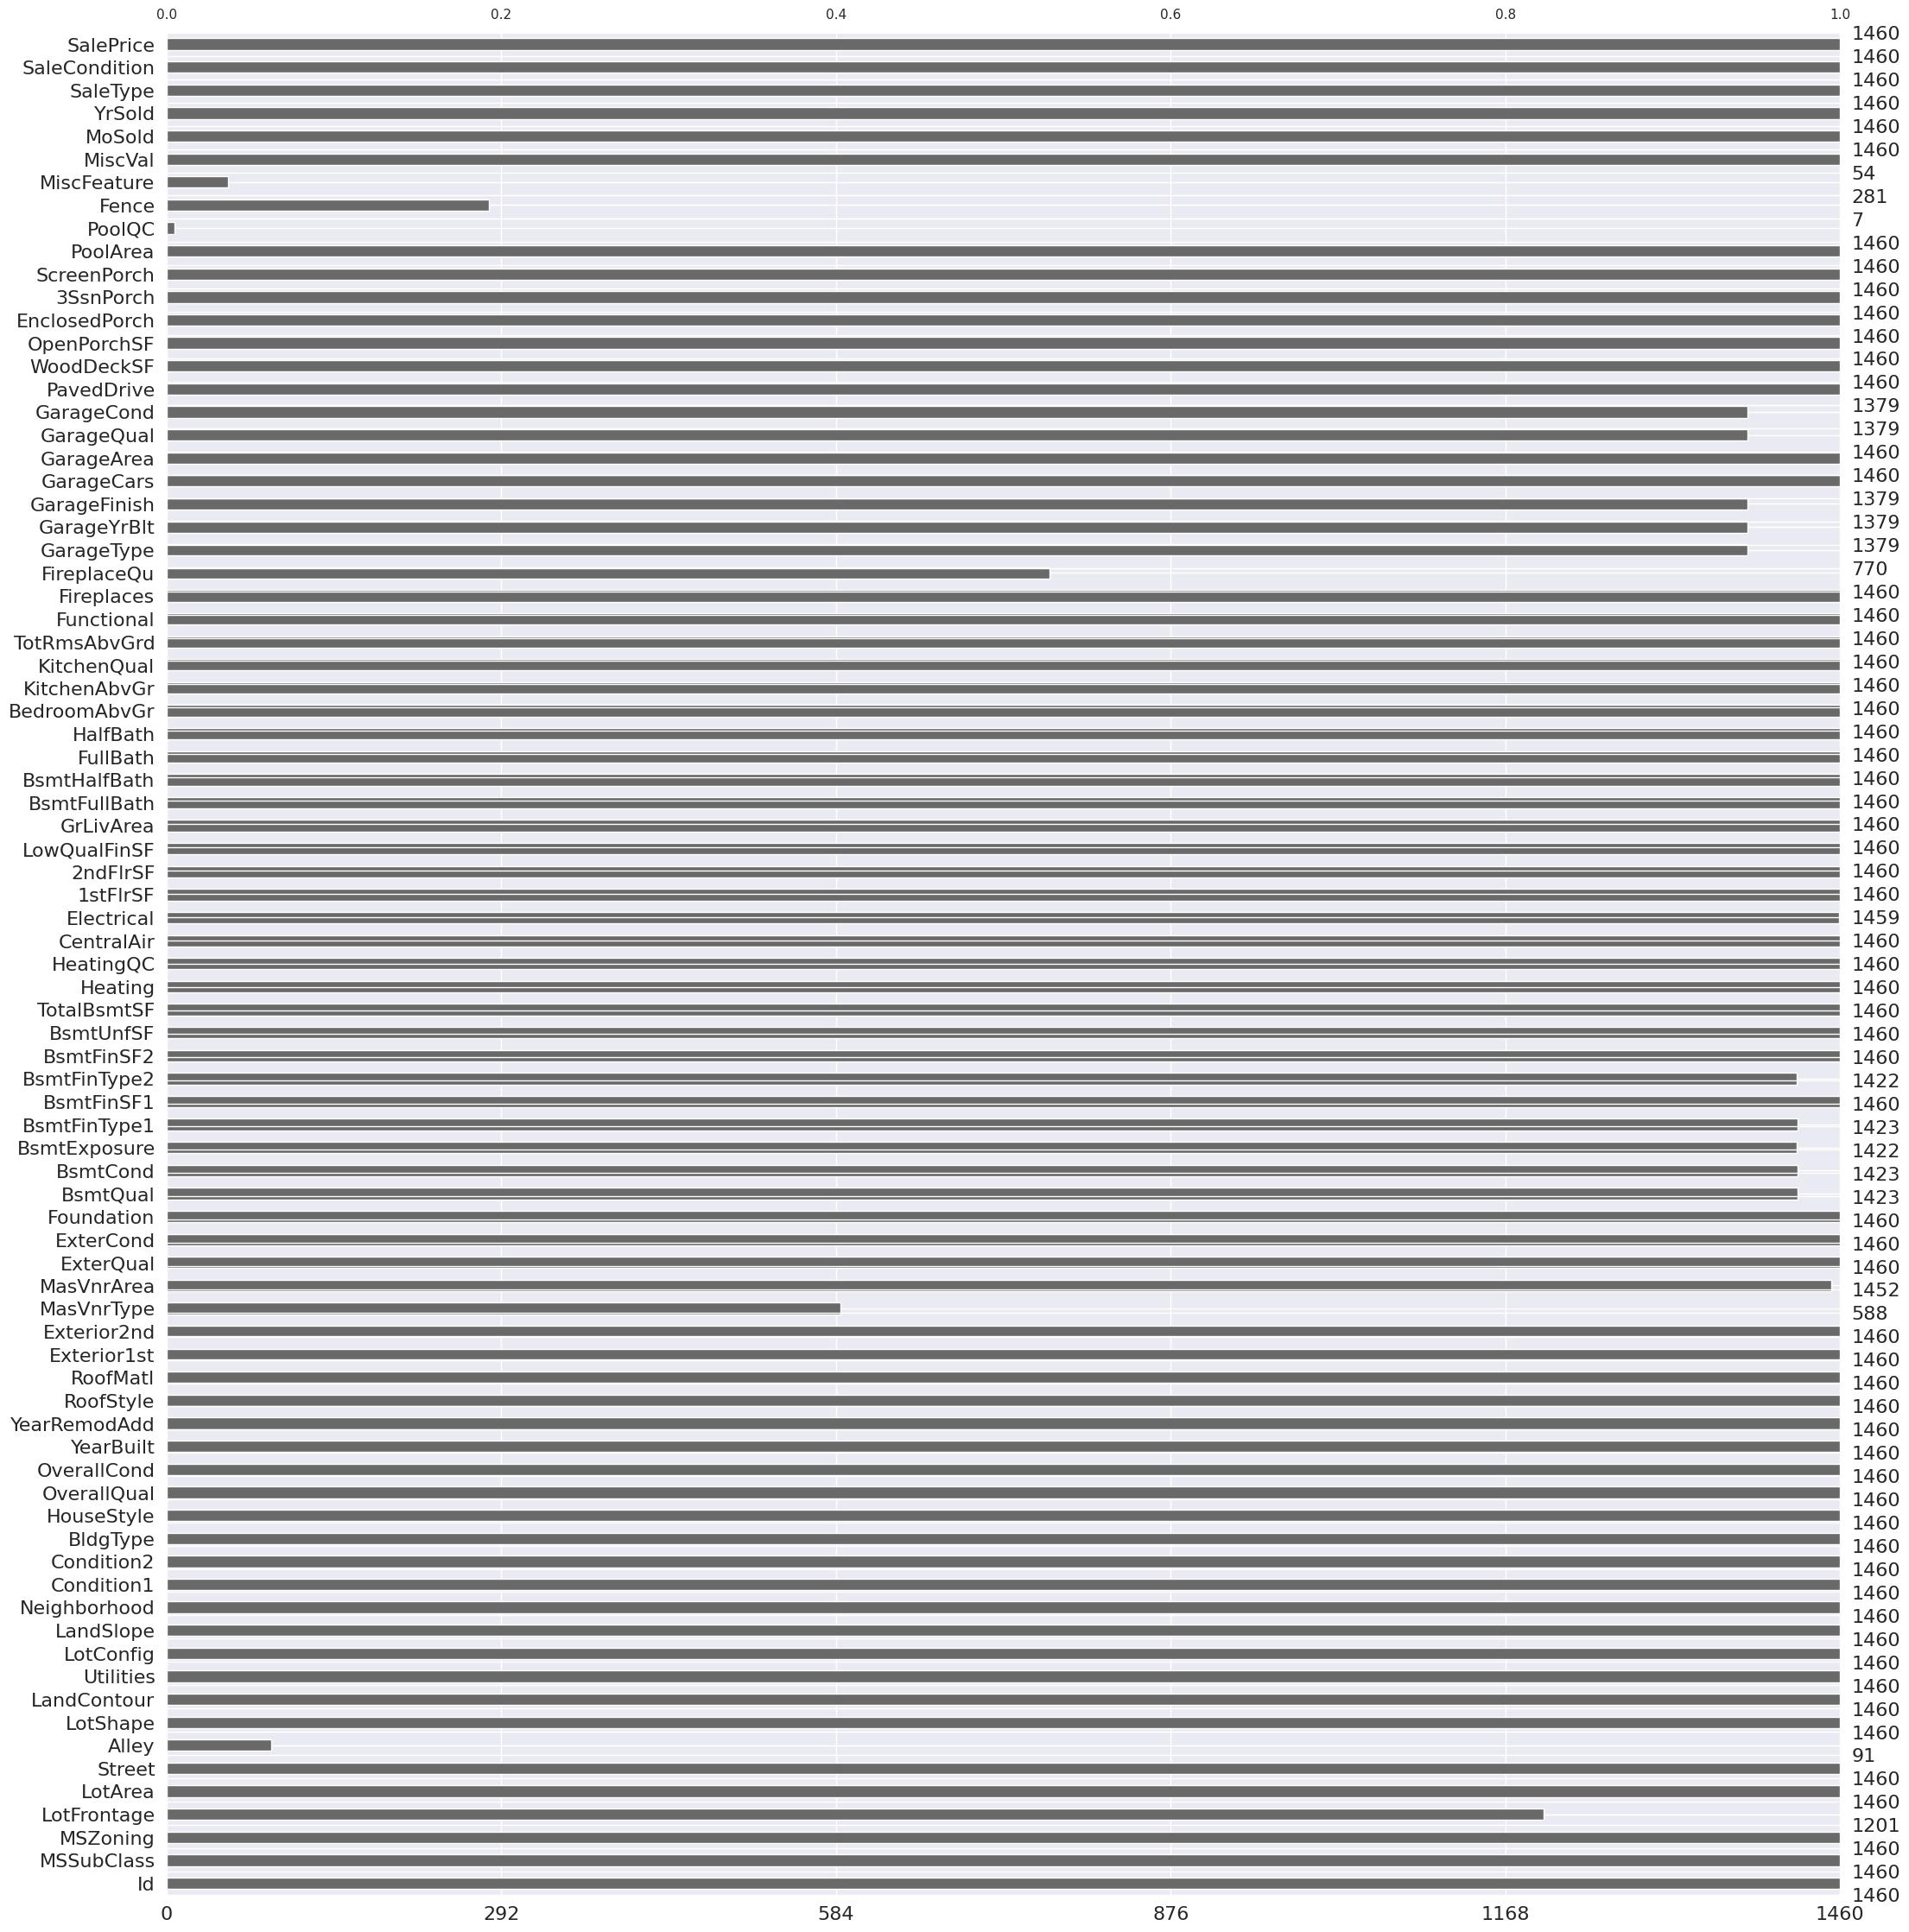

In [253]:
msno.bar(train)

<Axes: >

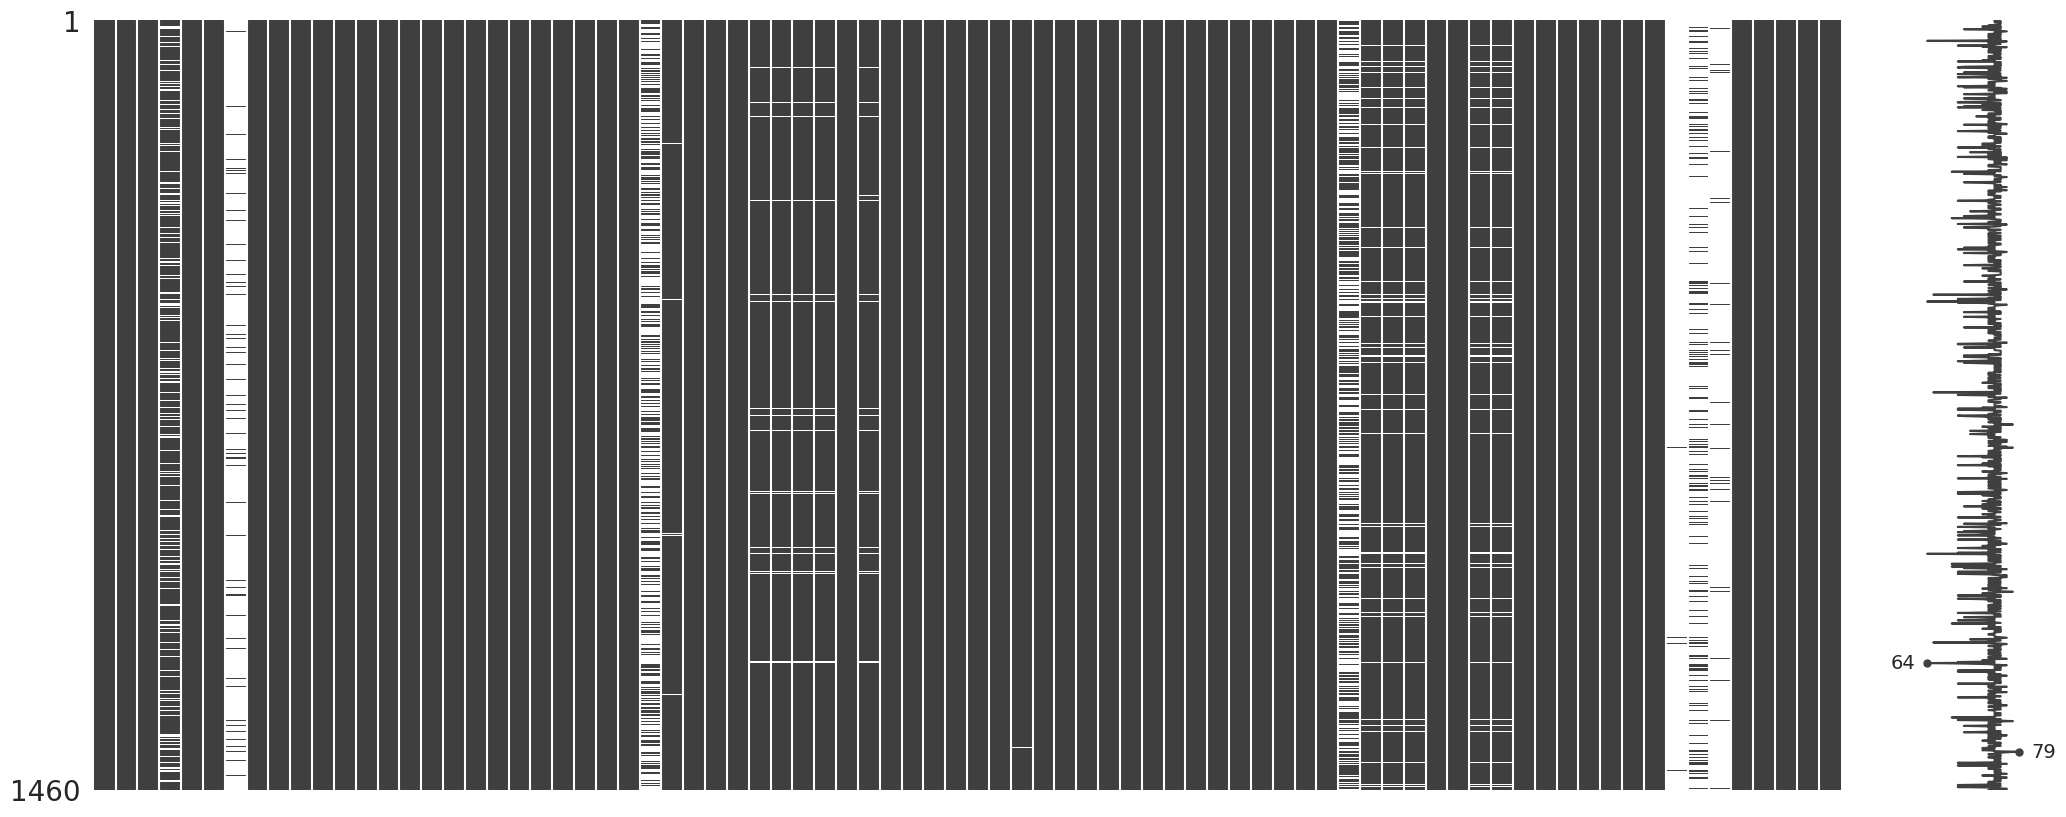

In [254]:
msno.matrix(X)

## Начало

In [261]:
t = pd.DataFrame(data={'NaN_count': X.isna().sum(), 'data_type':X.dtypes})
gaps = t.loc[t['NaN_count'] > 0]

In [265]:
gaps.to_excel('gaps.xlsx')

In [237]:
num_features

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


## Preprocessering

In [ ]:
def remove_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column[(column >= lower_bound) & (column <= upper_bound)]

In [267]:
t = pd.DataFrame(data={'NaN_count': X.isna().sum(), 'data_type':X.dtypes})

cols_to_fill = ['Alley', 'PoolQC','Fence','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                 'FireplaceQu','GarageType', 'GarageFinish','GarageQual','GarageCond','MasVnrType']

garage_year = ['GarageYrBlt']

electrical = ['Electrical']

LotFrontage = ['LotFrontage']

MasVn = ['MasVnrArea']

drop_cols = ['MiscFeature']

class MasVnrType_modify(BaseEstimator, TransformerMixin): 
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        X_copy = X.copy()

        ff = ((X_copy['MasVnrArea'] == 0)  & (X_copy['MasVnrType'] != 'NO'))
        X_copy.loc[ff,'MasVnrArea'] = X_copy['MasVnrArea'].loc[X_copy['MasVnrType'] == 'Stone'].median()
        
        f = ((X_copy['MasVnrArea'] != 0)  & (X_copy['MasVnrType'] == 'NO'))
        X_copy.loc[f,'MasVnrType'] = 'BrkFace'
        
        return X_copy

MasVnrType = ColumnTransformer(
    transformers = [
        ('MasVnrType_modify', MasVnrType_modify(), ['MasVnrArea','MasVnrType']),
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

imputer = ColumnTransformer(
     transformers = [
        ('fillna' , SimpleImputer(strategy='constant', fill_value='NO') , cols_to_fill),
        ('garage_YER' , SimpleImputer(strategy='constant', fill_value= -1) , garage_year),
        ('drop_col' , 'drop', drop_cols),
        ('mod_electrical', SimpleImputer(strategy='most_frequent'), electrical),
        ('Median_value', SimpleImputer(strategy='median'), LotFrontage),
        ('MasVn_zero', SimpleImputer(strategy='constant', fill_value= 0), MasVn)   
     ],
     verbose_feature_names_out = False,
     remainder = 'passthrough')

# columns_to_impute = ['Alley', 'PoolQC','Fence','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
#                  'FireplaceQu','GarageType', 'GarageFinish','GarageQual','GarageCond','MasVnrType', 'GarageYrBlt', 'Electrical', 'LotFrontage', 'MasVnrArea']

# imputer = ColumnTransformer(
#     transformers=[
#         ('iterative_imputer', IterativeImputer(max_iter=10, random_state=0), columns_to_impute),

#     ],
#     remainder='passthrough'
# )

value_type = pd.DataFrame(data={'data_type':X.dtypes}).loc[t['data_type'] != object]

list_standart_scaler = value_type.index.to_list()

ordinal_encoding_columns = ['PoolQC', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'HeatingQC', 'CentralAir', 'KitchenQual', 'PavedDrive', 'Functional']
one_hot_encoding_columns = ['Alley', 'GarageType', 'MasVnrType', 'Electrical', 'MSZoning', 'Street', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'SaleType', 'SaleCondition', 'Fence']

encoding_columns = ordinal_encoding_columns + one_hot_encoding_columns 

scaler_encoder = ColumnTransformer(
    [
        # ('ordinal_encoding', OrdinalEncoder(), ordinal_encoding_columns),
        ('one_hot_encoding', CatBoostEncoder(), encoding_columns),
        ('standard_scaling', StandardScaler(), list_standart_scaler),
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)

preprocessor = Pipeline(
    [
        ('imputer', imputer),
        ('MasVnrType', MasVnrType),
        ('Encoding_and_scaling',scaler_encoder)   
    ]
)

In [268]:
preprocessor

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fillna',
                                                  SimpleImputer(fill_value='NO',
                                                                strategy='constant'),
                                                  ['Alley', 'PoolQC', 'Fence',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond',
                                                   'MasVnrType']),
                                                 ('garage_YER',
                                                  SimpleImputer(fi...
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'BedroomAbvGr',
                                                   'KitchenAbvGr',
                                                   'TotRmsAbvGrd', 'Fireplaces',
                                                   'GarageYrBlt', 'GarageCars',
                                                   'GarageArea', 'WoodDeckSF',
                                                   'OpenPorchSF', ...])],
                                   verbose_feature_names_out=False))])

In [266]:
preprocessor.fit_transform(X, y)

,PoolQC,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageFinish,GarageQual,GarageCond,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,180921.195890,180921.195890,180921.195890,180921.195890,180921.195890,180921.195890,180921.195890,180921.195890,180921.195890,180921.195890,...,0.351000,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777
1,194710.597945,194710.597945,194710.597945,180921.195890,180921.195890,194710.597945,180921.195890,194710.597945,194710.597945,194710.597945,...,-0.060731,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439
2,190307.065297,190307.065297,190307.065297,180921.195890,194710.597945,190307.065297,181210.597945,190307.065297,190307.065297,190307.065297,...,0.631726,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777
3,198605.298973,180921.195890,180921.195890,194710.597945,181210.597945,198605.298973,180921.195890,180921.195890,198605.298973,198605.298973,...,0.790804,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655
4,186884.239178,198605.298973,198605.298973,180921.195890,204307.065297,186884.239178,195307.065297,198605.298973,186884.239178,186884.239178,...,1.698485,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,180378.034642,202686.225601,183676.347245,165524.799154,170684.346967,184634.224857,205728.760243,201929.891202,187481.997855,187879.183961,...,-0.060731,-0.752176,-0.100558,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.620891,-0.614439
1456,180374.325652,202641.425883,183669.719019,165534.762561,161440.891800,164798.513130,205630.585290,142108.331450,187472.455043,187869.449128,...,0.126420,2.033231,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,1.645210
1457,180394.743071,140615.020396,212283.310706,165581.469744,235432.209103,184626.554296,226126.208410,201866.076294,187489.664779,187886.164045,...,-1.033914,-0.752176,0.201405,-0.359325,-0.116339,-0.270208,-0.068692,4.953112,-0.489110,1.645210
1458,180454.044212,140809.287339,183689.818470,193129.975403,235506.533961,165635.577702,141378.837730,142220.549084,187549.978012,187945.495242,...,-1.090059,2.168910,-0.704483,1.473789,-0.116339,-0.270208,-0.068692,-0.087688,-0.859110,1.645210


### SHAP

In [ ]:
from catboost import CatBoostRegressor
shap.initjs()


## First Model build

### PCA

In [91]:
pca = PCA(n_components=15).set_output(transform='pandas')

In [ ]:
X_copy = X.copy()

X_PCA = preprocessor.fit_transform(X_copy, y)

In [92]:
x_pca = pca.fit_transform(X_PCA, y)

In [93]:
pca.explained_variance_ratio_.sum()

0.8683918702708004

In [87]:
x_pca 

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24
0,-4000.971634,2095.785888,1567.397840,-302.449555,1247.595067,-1104.747055,1385.687322,1337.329186,-2778.123946,158.207202,...,337.735249,-1861.958849,-356.852905,-329.058520,2590.084802,143.147074,-889.390619,2275.576999,569.294265,-514.359100
1,22437.336292,-19337.930529,-12447.226288,1470.609101,13058.349296,12696.739842,-12439.757289,-18443.816548,8186.672219,-4659.111802,...,-5010.382014,14496.140963,2997.852472,17589.500765,-16129.470918,-1851.825181,3714.293040,-13478.436112,1825.639592,444.573548
2,43221.682971,-1535.171716,-14949.893759,-1067.847372,2767.888308,-511.761086,-5511.031290,1832.864090,11667.880122,-833.257326,...,-1418.852972,14564.574380,2507.933016,6797.276178,-14242.356175,-1162.752209,479.746285,-13875.174935,-769.855998,9754.699563
3,20942.151107,-12197.183031,-644.145867,-357.869934,-2040.305344,11206.260020,-15896.231934,-17020.191061,22066.948091,14449.915894,...,4848.375993,31780.733526,14816.244093,17620.874929,-25020.270480,-3222.909118,5080.139552,-16866.854956,377.690328,16381.264814
4,57787.289617,-750.613181,-24495.354946,10694.875701,6436.024887,10928.550606,12060.747995,9161.568654,6914.573133,-15141.582140,...,-9014.962111,4619.227893,969.557612,4408.563074,-6160.722331,492.380055,-2602.070981,-10857.593943,-1576.288621,3280.260652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,18749.120390,-32171.527813,-61304.265197,3118.865288,11745.132279,-42325.070684,50042.331619,-29038.193313,-12184.777669,-22390.496562,...,10039.203078,-3153.158195,-6278.830644,-20292.067285,1728.883681,-3387.956896,2151.453162,-3640.120389,-282.010791,2099.617329
1456,-35378.635364,-44032.795346,27902.578769,-8399.439271,62039.531176,-6288.847463,9074.178048,78044.775162,8238.779653,9716.699956,...,-10098.156830,-7915.085129,-17546.384247,-8167.885421,22494.635144,12411.026843,-9129.971222,5945.044095,-8928.496204,23326.754619
1457,116523.553407,24305.956700,14424.021620,54382.862896,-82751.621649,-36279.998603,1693.175063,14602.924157,-21889.231870,-31872.922901,...,-21863.184110,54260.082781,-19423.265927,-21994.463474,11989.384028,6204.983038,-13956.005327,-12535.914301,2003.425097,-496.689550
1458,-65510.518014,3683.385178,16878.716873,-25040.703894,-33173.651601,42041.101086,-33241.002754,-15154.738589,36122.837707,35328.747754,...,-16633.627693,-120.502651,31720.563742,-17678.491213,-35183.987156,8943.718157,-11796.008733,-4506.282132,47312.199418,-3725.609941


### Feature importance 

In [242]:
X_copy = X.copy()

rf = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=2)
X_RF = preprocessor.fit_transform(X_copy, y)
rf.fit(X_RF, y)

feature_importance = pd.Series(dict(zip(X.columns, rf.feature_importances_))).sort_values(key=lambda x: abs(x), ascending=False)

In [243]:
pd.set_option('display.max_rows', 80)

In [244]:
feature_importance

GrLivArea        0.718234
GarageType       0.092172
ExterCond        0.056162
Fireplaces       0.039578
EnclosedPorch    0.020306
TotRmsAbvGrd     0.016007
Functional       0.014913
BedroomAbvGr     0.008276
3SsnPorch        0.005992
MSSubClass       0.004759
PavedDrive       0.003446
GarageCars       0.003017
HalfBath         0.002458
LowQualFinSF     0.002151
Neighborhood     0.001999
HouseStyle       0.001218
Alley            0.001166
BsmtHalfBath     0.001061
BsmtUnfSF        0.000603
YearRemodAdd     0.000600
BsmtFinType1     0.000377
LotShape         0.000371
BsmtExposure     0.000349
WoodDeckSF       0.000325
FullBath         0.000293
GarageFinish     0.000261
Id               0.000259
MiscFeature      0.000245
RoofStyle        0.000227
Electrical       0.000185
LotArea          0.000179
MasVnrType       0.000177
HeatingQC        0.000177
2ndFlrSF         0.000174
MiscVal          0.000167
ScreenPorch      0.000161
TotalBsmtSF      0.000158
GarageQual       0.000152
BsmtFinSF1  

In [95]:
important_features_fi = feature_importance[feature_importance > 0.001].index.to_list()
important_features_pca = feature_importance[:15].index.to_list()

In [146]:
important_features_pca


['GrLivArea',
 'GarageType',
 'ExterCond',
 'Fireplaces',
 'EnclosedPorch',
 'TotRmsAbvGrd',
 'Functional',
 'BedroomAbvGr',
 '3SsnPorch',
 'MSSubClass',
 'PavedDrive',
 'GarageCars',
 'HalfBath',
 'LowQualFinSF',
 'Neighborhood']

### Lasso

In [97]:
X_copy = X.copy()
X_lasso = preprocessor.fit_transform(X_copy, y)

In [197]:
lasso = Lasso(alpha=0.95)
lasso.fit(X_lasso, y)

Lasso(alpha=0.95)

In [198]:
lasso_features = pd.Series(dict(zip(X.columns, lasso.coef_))).sort_values(key=lambda x: abs(x), ascending=False)

In [199]:
lasso_features


Fireplaces       25315.470787
Functional       18219.912361
GrLivArea        16905.837196
GarageCond      -12099.248025
EnclosedPorch    11931.418508
1stFlrSF        -10141.068553
PavedDrive        7875.565120
GarageYrBlt       6317.663118
BsmtFullBath      5317.420861
BedroomAbvGr      5244.229932
HalfBath          4977.941279
GarageType        4069.573341
ScreenPorch       3978.851930
WoodDeckSF        2513.889746
2ndFlrSF         -2481.998263
GarageQual       -2412.577082
BsmtHalfBath     -2093.920278
GarageCars        1902.184849
FullBath         -1853.852184
LowQualFinSF      1348.611371
KitchenQual      -1342.266589
GarageArea        1215.579007
YrSold            -829.868061
PoolArea           703.136121
Electrical         580.249623
OpenPorchSF       -515.656336
SaleType          -394.650338
3SsnPorch          314.462769
GarageFinish      -231.322825
MiscFeature         51.285493
Fence               25.116317
PoolQC              17.562464
FireplaceQu         13.807796
MasVnrArea

In [200]:
important_features_l1 = lasso_features[lasso_features > 0].index.to_list()
important_features_l1.remove('MiscFeature')

In [201]:
len(important_features_l1)

50

### Random

In [62]:
X_copy = X.copy()

# X_copy['random'] = np.random.normal(0,0.5, size=X_copy.shape[0])
# X_copy['random'] = np.random.uniform(0,100, size=X.shape[0])

rf = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=2)

X_RF = preprocessor.fit_transform(X_copy, y)

rf.fit(X_RF, y)

result = pd.Series(dict(zip(X_RF.columns, rf.feature_importances_))).sort_values(key=lambda x: abs(x), ascending=False).to_frame().round(6)
result
# pd.set_option('display.max_rows', 80)

,0
OverallQual,0.718124
GrLivArea,0.092843
Neighborhood,0.056029
2ndFlrSF,0.038345
GarageCars,0.020306
...,...
LandSlope,0.000000
Condition2,0.000000
BsmtFinSF2,0.000000
OverallCond,0.000000


In [63]:
result.index.get_loc('random')

15

In [64]:
result.index.to_list().index('random')
OK = result.index.to_list()[:result.index.to_list().index('random')]

In [65]:
len(OK)

15

### Preproccessor with feature importance 

In [202]:
# t = pd.DataFrame(data={'NaN_count': X.isna().sum(), 'data_type':X.dtypes})

# cols_to_fill = ['Alley', 'PoolQC','Fence','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
#                  'FireplaceQu','GarageType', 'GarageFinish','GarageQual','GarageCond','MasVnrType']

# garage_year = ['GarageYrBlt']

# electrical = ['Electrical']

# LotFrontage = ['LotFrontage']

# MasVn = ['MasVnrArea']

# drop_cols = ['MiscFeature']

# imputer = ColumnTransformer(
#      transformers = [
#         ('fillna' , SimpleImputer(strategy='constant', fill_value='NO') , cols_to_fill),
#         ('garage_YER' , SimpleImputer(strategy='constant', fill_value= -1) , garage_year),
#         ('drop_col' , 'drop', drop_cols),
#         ('mod_electrical', SimpleImputer(strategy='most_frequent'), electrical),
#         ('Median_value', SimpleImputer(strategy='median'), LotFrontage),
#         ('MasVn_zero', SimpleImputer(strategy='constant', fill_value= 0), MasVn)   
#      ],
#      verbose_feature_names_out = False,
#      remainder = 'passthrough')

# class MasVnrType_modify(BaseEstimator, TransformerMixin): 
    
#     def fit(self, X, y=None):
#         return self
        
#     def transform(self, X, y=None):
#         X_copy = X.copy()

#         ff = ((X_copy['MasVnrArea'] == 0)  & (X_copy['MasVnrType'] != 'NO'))
#         X_copy.loc[ff,'MasVnrArea'] = X_copy['MasVnrArea'].loc[X_copy['MasVnrType'] == 'Stone'].median()
        
#         f = ((X_copy['MasVnrArea'] != 0)  & (X_copy['MasVnrType'] == 'NO'))
#         X_copy.loc[f,'MasVnrType'] = 'BrkFace'
        
#         return X_copy

# MasVnrType = ColumnTransformer(
#     transformers = [
#         ('MasVnrType_modify', MasVnrType_modify(), ['MasVnrArea','MasVnrType']),
#     ],
#     verbose_feature_names_out = False,
#     remainder = 'passthrough' 
# )

# value_type = pd.DataFrame(data={'data_type':X.dtypes}).loc[t['data_type'] != object]

# list_standart_scaler = value_type.index.to_list()

# ordinal_encoding_columns = ['PoolQC', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'HeatingQC', 'CentralAir', 'KitchenQual', 'PavedDrive', 'Functional']
# one_hot_encoding_columns = ['Alley', 'GarageType', 'MasVnrType', 'Electrical', 'MSZoning', 'Street', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'SaleType', 'SaleCondition', 'Fence']

# encoding_columns = ordinal_encoding_columns + one_hot_encoding_columns 

# scaler_encoder = ColumnTransformer(
#     [
#         # ('ordinal_encoding', OrdinalEncoder(), ordinal_encoding_columns),
#         ('one_hot_encoding', CatBoostEncoder(), encoding_columns),
#         ('standard_scaling', RobustScaler(), list_standart_scaler),
#     ],
#     verbose_feature_names_out = False,
#     remainder = 'passthrough' 
# )

# feature_drop = ColumnTransformer(
#     [
#         ('feature_drop', 'drop', important_features_l1),
#     ],
#     verbose_feature_names_out = False,
#     remainder = 'passthrough' 
# )

# preprocessor = Pipeline(
#     [
#         ('imputer', imputer),
#         ('MasVnrType', MasVnrType),
#         ('Encoding_and_scaling',scaler_encoder),  
#         ('Features_droping', feature_drop)
#     ]
# )

# CatBoost

In [22]:
from catboost import CatBoostRegressor
y_log = np.log(y)
X_train, X_valid, y_train, y_valid = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [262]:
ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', CatBoostRegressor(iterations=3000, learning_rate=0.04, depth=4, random_seed=42))
    ]
)

# ml_pipeline.fit(X_train, y_train)

In [216]:
y_pred = ml_pipeline.predict(X_valid)

In [34]:
# CatBoost с CatBoostEncoder и RobustScaler = 0.009622276274671989
rmsle1 = root_mean_squared_log_error(y_valid, y_pred)
rmsle1

0.009622276274671989

In [145]:
# CatBoost с CatBoostEncoder и RobustScaler = 25617.179263680933
mse1 = mean_squared_error(np.exp(y_valid), np.exp(y_pred), squared = False)

25617.179263680933

In [151]:
# CatBoost с CatBoostEncoder и RobustScaler и выброшенными фичами по PCA = 27294.28664316027
mse2 = mean_squared_error(np.exp(y_valid), np.exp(y_pred), squared = False)

In [156]:
# CatBoost с CatBoostEncoder и RobustScaler и выброшенными фичами по f_i = 26552.475624278082
mse3 = mean_squared_error(np.exp(y_valid), np.exp(y_pred), squared = False)

In [166]:
# CatBoost с CatBoostEncoder и RobustScaler и выброшенными фичами по Lasso = 29759.757670463863
mse4 = mean_squared_error(np.exp(y_valid), np.exp(y_pred), squared = False)

In [217]:
# CatBoost с CatBoostEncoder и StandardScaler = 25616.62205627369
mse5 = mean_squared_error(np.exp(y_valid), np.exp(y_pred), squared = False)

In [176]:
# CatBoost с CatBoostEncoder и StandardScaler и выброшенными фичами по PCA = 27294.28664316027
mse6 = mean_squared_error(np.exp(y_valid), np.exp(y_pred), squared = False)

In [205]:
# CatBoost с CatBoostEncoder и StandardScaler и выброшенными фичами по Lasso (alpha=0.8) = 33264.70756702563
mse7 = mean_squared_error(np.exp(y_valid), np.exp(y_pred), squared = False)

In [218]:
mse5

25616.62205627369

## Feature analysis + drop

#### Решили оставить самые важные колонки


In [7]:
cools_to_fill = ['Alley', 'PoolQC','Fence','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                 'FireplaceQu','GarageType', 'GarageFinish','GarageQual','GarageCond','MasVnrType']
drop_colums = ['MiscFeature']

garage_YER = ['GarageYrBlt']

Elect = ['Electrical']

Medin = ['LotFrontage']

MasVn = ['MasVnrArea']

fill_na = ColumnTransformer(
     transformers = [
        ('fillna' , SimpleImputer(strategy='constant', fill_value='NO') , cools_to_fill),
        ('garage_YER' , SimpleImputer(strategy='constant', fill_value= -1) , garage_YER),
        ('drop_col' , 'drop', drop_colums ),
        ('mod_electrical', SimpleImputer(strategy='most_frequent'), Elect),
        ('Median_value', SimpleImputer(strategy='median'), Medin),
        ('MasVn_zero', SimpleImputer(strategy='constant', fill_value= 0 ), MasVn)   
     ],
     verbose_feature_names_out = False,
     remainder = 'passthrough')

class MasVnrType_modify(BaseEstimator, TransformerMixin): 
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        X_copy = X.copy()

        ff = ((X_copy['MasVnrArea'] == 0)  & (X_copy['MasVnrType'] != 'NO'))
        X_copy.loc[ff,'MasVnrArea'] = X_copy['MasVnrArea'].loc[X_copy['MasVnrType'] == 'Stone'].median()
        
        f = ((X_copy['MasVnrArea'] != 0)  & (X_copy['MasVnrType'] == 'NO'))
        X_copy.loc[f,'MasVnrType'] = 'BrkFace'
        
        return X_copy

MasVnrType = ColumnTransformer(
    transformers = [
        ('MasVnrType_modify', MasVnrType_modify(), ['MasVnrArea','MasVnrType']),
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)
t = pd.DataFrame(data={'NaN_count': X.isna().sum(), 'data_type':X.dtypes})
value_type = pd.DataFrame(data={'data_type':X.dtypes}).loc[t['data_type'] != object]

list_standart_scaler = value_type.index.to_list()
ordinal_encoding_columns = ['PoolQC', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'HeatingQC', 'CentralAir', 'KitchenQual', 'PavedDrive', 'Functional']
target_encoding_columns = ['Alley', 'GarageType', 'MasVnrType', 'Electrical', 'MSZoning', 'Street', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'SaleType', 'SaleCondition', 'Fence']

super_target = ordinal_encoding_columns+target_encoding_columns

my_encoder = ColumnTransformer(
    [
        ('ordinal_encoding', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), super_target),
        # ('target_encoding_columns', TargetEncoder(), target_encoding_columns),
        ('scaling_num_columns', StandardScaler(), list_standart_scaler),
        # ('target_encoding_columns', TargetEncoder(), super_target)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)


super_drop = ColumnTransformer(
    [
        ('dropdropdrop', 'drop', NOT_OK ),
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)



preprocessor = Pipeline(
    [
        ('fill_na', fill_na),
        ('MasVnrType',MasVnrType),
        ('Encoding_and_scaling',my_encoder),
        ('drop+',super_drop),
        # ()
        
    ]
)

## Main model + Pipeline

>Catboost

In [9]:
from catboost import CatBoostRegressor

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
model = CatBoostRegressor(iterations=3000, learning_rate=0.04, depth=4, random_seed=42)

ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

ml_pipeline.fit(X_train, y_train)

ValueError: Pandas output does not support sparse data. Set sparse_output=False to output pandas dataframes or disable Pandas output via` ohe.set_output(transform="default").

In [82]:
y_pred = ml_pipeline.predict(X_valid)


root_mean_squared_error(y_true=y_valid, y_pred=y_pred)

28455.997824568774

## OPTUNE

In [17]:
ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor())
    ]
)


def objective(trial):
    
    # Параметры самой модели
    model_params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800, 25),
        'max_depth' : trial.suggest_int('max_depth', 2, 8, 1),
        'random_state': trial.suggest_int('random_state', 42, 42, 1)
    }
    
    
    ml_pipeline.named_steps['model'].set_params(**model_params)

    # Создание сплитов для кросс-валидации
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    # Вычисление метрик точности с использованием кросс-валидации
    scores = cross_val_score(ml_pipeline, X, y, cv=cv)
    
    accuracy = scores.mean()
    
    return accuracy


# Создание объекта для проведения оптимизации
study = optuna.create_study(direction='maximize')


# Запуск оптимизации
study.optimize(objective, n_trials=200)


# Вывод результатов
best_params = study.best_params
best_value = study.best_value


print(f"Лучшие параметры: {best_params}")
print(f"Лучшее значение: {best_value}")

## CROSS VALIDATION

In [13]:
cat = CatBoostRegressor(iterations=3000, learning_rate=0.04366383,depth=7, random_seed=42)
RFR = RandomForestRegressor(max_depth=6, n_estimators=750)
VC = VotingRegressor(
    [
        ('RFR', RFR),
        ('CATBoost', cat)
    ]
)

STC = StackingRegressor(
    estimators=[
        ('RFR',RFR),
        ('catboost',cat)
    ])


ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', STC)
    ]
)

ml_pipeline.fit(X_train,y_train)

0:	learn: 75124.0850540	total: 56.8ms	remaining: 2m 50s
1:	learn: 73070.6112961	total: 59ms	remaining: 1m 28s
2:	learn: 71161.9627158	total: 61.5ms	remaining: 1m 1s
3:	learn: 69283.8835955	total: 67.2ms	remaining: 50.3s
4:	learn: 67566.4242050	total: 68.7ms	remaining: 41.1s
5:	learn: 65840.4969141	total: 70.5ms	remaining: 35.2s
6:	learn: 64273.7976933	total: 72.1ms	remaining: 30.8s
7:	learn: 62523.3544811	total: 73.8ms	remaining: 27.6s
8:	learn: 60984.2491554	total: 75.6ms	remaining: 25.1s
9:	learn: 59676.7287069	total: 77.1ms	remaining: 23s
10:	learn: 58313.0130280	total: 78.8ms	remaining: 21.4s
11:	learn: 56863.8070855	total: 80.5ms	remaining: 20s
12:	learn: 55608.7284126	total: 83.4ms	remaining: 19.2s
13:	learn: 54326.2798259	total: 85.8ms	remaining: 18.3s
14:	learn: 53205.9678512	total: 88ms	remaining: 17.5s
15:	learn: 52181.4276937	total: 89.5ms	remaining: 16.7s
16:	learn: 50948.6025945	total: 91.1ms	remaining: 16s
17:	learn: 49861.9232134	total: 94ms	remaining: 15.6s
18:	learn: 4

KeyboardInterrupt: 

In [22]:
y_pred = ml_pipeline.predict(X_valid)


root_mean_squared_error(y_true=y_valid, y_pred=y_pred)

27494.85064204261

In [ ]:
models = {'catboost':cat, 'VC':VC, 'STC':STC}

cv = KFold(n_splits=5, random_state=42, shuffle=True)
d = []
for name, model in models.items():
    ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        (name, model)
    ]
)
    ml_pipeline.fit(X_train, y_train)

    train = root_mean_squared_error(y_train, ml_pipeline.predict(X_train))
    valid = root_mean_squared_error(y_valid, ml_pipeline.predict(X_valid))
    

    
    cross_validation_result = cross_val_score(
        ml_pipeline,
        X,
        y,
        cv = cv,)
    
    x = [name, train, valid, cross_validation_result.mean()]
    d.append(x)

final = pd.DataFrame(d).rename(columns={0:'Model',1:'train score',2:'valid score',3:'cross validation'}).sort_values('cross validation', ascending = False)

In [97]:
final

,Model,train score,valid score,cross validation
0,catboost,343.415844,27869.244690,0.863100
2,RFR,28336.254536,35096.771292,0.783503
1,linearR,32588.159126,36569.493257,0.712675


## Log END

In [14]:
# cat = CatBoostRegressor(iterations=3000, learning_rate=0.04366383,depth=7, random_seed=42)
# RFR = RandomForestRegressor(max_depth=6, n_estimators=750)

# STC = StackingRegressor(
#     estimators=[
#         ('RFR',RFR),
#         ('catboost',cat)
#     ])
# ml_pipeline = Pipeline(
#     [
#         ('preprocessor', preprocessor),
#         ('model', STC)
#     ]
# )

In [231]:
y_pred = ml_pipeline.predict(test)

In [232]:
y_pred

array([11.75120261, 11.98302288, 12.15300661, ..., 11.98750937,
       11.65456895, 12.28681059])

In [233]:
y_pred_final = np.exp(y_pred)

In [225]:
y_pred_final

array([126906.08572505, 160015.00691337, 189663.4773488 , ...,
       160734.52505543, 115216.58161667, 216817.35312021])

In [226]:
id = np.arange(1461, 2920)

In [234]:
submission = pd.DataFrame(y_pred_final).rename(columns={0:'SalePrice'}).set_index(id)

In [228]:
submission

,SalePrice
1461,126906.085725
1462,160015.006913
1463,189663.477349
1464,200998.870968
1465,186562.296020
...,...
2915,79006.563509
2916,81299.665031
2917,160734.525055
2918,115216.581617


In [235]:
submission.to_csv('submission.csv')

In [263]:
import joblib
# joblib.dump(ml_pipeline_stc2, 'aux/model_stc.pkl')
joblib.dump(ml_pipeline, 'model_catboost.pkl')

['model_catboost.pkl']